In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [2]:
X=np.load("X_train.npy").reshape(-1,1,50,37)
y=np.load("y_train.npy").astype(np.int32)
X.shape

(966, 1, 50, 37)

In [3]:
def draw_image(data):
    img=data.reshape(50,37)
    
    plt.imshow(img)
    plt.gray()
    plt.show()

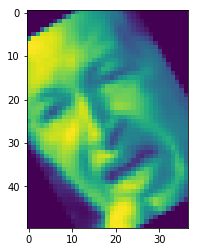

In [4]:
size=(X[0].shape[2],X[0].shape[1])
center=(int(size[0]/2),int(size[1]/2))
angle=30
scale=1.0
rotation_matrix=cv2.getRotationMatrix2D(center,angle,scale)
rotated=cv2.warpAffine(X[0].reshape(50,37),rotation_matrix,size)

plt.imshow(rotated)

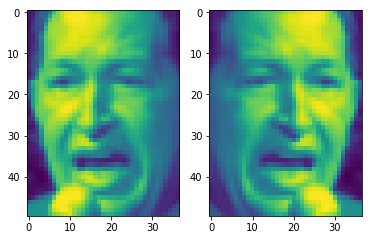

In [5]:
flipped=np.fliplr(X[0].reshape(50,37))

plt.subplot(1,2,1)
plt.imshow(X[0].reshape(50,37))

plt.subplot(1,2,2)
plt.imshow(flipped)


In [6]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [7]:
print(X_train.shape)
print(X_test.shape)

(676, 1, 50, 37)
(290, 1, 50, 37)


In [8]:
def label_info(index):
    draw_image(X[index])
    
    print("label:"+str(y[index]))
    

In [9]:
X_train /=255
X_test /=255


In [10]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer.datasets import tuple_dataset,TransformDataset
from chainer.training import extensions
from chainer import optimizers,serializers,training,iterators

C:\Users\yuubo\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
# CNNの定義
class CNN(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=1, out_channels=64, ksize=4, stride=1, pad=2)
            self.conv2 = L.Convolution2D(in_channels=64, out_channels=128, ksize=4, stride=1, pad=2)
            self.conv3 = L.Convolution2D(in_channels=None, out_channels=128, ksize=4, stride=1, pad=2) # in_channelをNoneで省略
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(None, 7) # out_channelはクラス数と同じ5に設定
        
        
    def __call__(self, X):
        h = F.relu(F.max_pooling_2d(self.conv1(X), ksize=2)) # conv1の畳み込みのあとにMaxPoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv2(h), ksize=2)) # conv2の畳み込みのあとにMaxPpoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv3(h), ksize=2)) # conv3の畳み込みのあとにMaxPoolingを実行
        h = F.relu(self.fc4(h))
        return self.fc5(h)

In [12]:
# 分類器インスタンスの生成
model = L.Classifier(CNN())

# optimizerの生成
optimizer = chainer.optimizers.SGD() # 今回はSGDを採用
optimizer.setup(model)               # モデルの構造を読み込ませる

# ミニバッチに含まれるサンプル数を指定
batchsize = 100

# epoch数を指定
n_epoch = 70

In [13]:
train=tuple_dataset.TupleDataset(X_train,y_train)
test=tuple_dataset.TupleDataset(X_test,y_test)


In [14]:
def get_augmented(img,random_crop=4):
    img=img.reshape(50,37)
    
    if np.random.rand() > 0.5:
        img=np.fliplr(img)
    
    if np.random.rand() > 0.5:
        size=(img.shape[0],img.shape[1])
        center=(int(size[0]/2),int(size[1]/2))
        angle=np.random.randint(-30,30)
        scale=1.0
        rotation_matrix=cv2.getRotationMatrix2D(center,angle,scale)
        img=cv2.warpAffine(img,rotation_matrix,size)
    
    img=img.reshape(1,50,37)
      
    return img

In [15]:
def process_image(inputs):
    image,label=inputs
    
    image -= np.mean(X_train)
    
    image /= image.max()
    
    image=get_augmented(image)
    
    return image,label
    

In [16]:
train=TransformDataset(train,process_image)
test=TransformDataset(test,process_image)

In [17]:
train_iter=iterators.SerialIterator(train,batch_size=batchsize,shuffle=True)
updater=training.StandardUpdater(train_iter,optimizer)
trainer=training.Trainer(updater,(n_epoch,"epoch"),out="result")

In [18]:
test_iter=iterators.SerialIterator(test,batch_size=batchsize,shuffle=False,repeat=False)
trainer.extend(extensions.Evaluator(test_iter,model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(["epoch","main/accuracy","main/loss","validation/main/accuracy","validation/main/loss"]))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(["main/accuracy","validation/main/accuracy"],"epoch",file_name="accuracy_LFW2.png"))
trainer.extend(extensions.PlotReport(["main/loss","validation/main/loss"],"epoch",file_name="loss_LFW2.png"))

In [ ]:
trainer.run()

epoch       main/accuracy  main/loss   validation/main/accuracy  validation/main/loss
1           0.355714       1.79412     0.408148                  1.70032               
2           0.41           1.66631     0.408148                  1.6881                
3           0.4            1.67507     0.408148                  1.67876               
4           0.411429       1.63004     0.408148                  1.66315               
5           0.413333       1.63326     0.408148                  1.66669               
6           0.415714       1.6219      0.408148                  1.65178               
7           0.412857       1.62498     0.408148                  1.65238               
8           0.44           1.57323     0.408148                  1.63604               
9           0.433333       1.59709     0.408148                  1.62731               
10          0.422857       1.59373     0.408148                  1.632                 
11          0.447143       1.55396